# IBM Coursera Project - The_Battle_of_Neighborhoods

## Table of contents

* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction: Business Problem <a name="introduction"></a>

Have some venture capital and would like to open a **restaurant** in the **Chicago** area?

Have troubles finding **where** to open the restaurant and **what** restaurant to open?

Will your restaurant **get popular** or will it be **cannibalized**?

The aim of this project is to help people who want to open a restaurant in the Chicago area find an **ideal restaurant location** and **profitable restaurant type**. The project will utilize **foursquare API** to collect necessary information for this analysis.

First, we will use geopy to get Chicago's latitude and longitude. 

Then we will find the top 30 venues in the Chicago area, since we would like open our restaurant in a popular place with enough human traffic. 

Third, we will collect restaurant information within each venue, cluster each venue based on its restaurant category information. 

Finally, we will plot the clustering information on the map and conduct some qualitative assesments.

# Data <a name="data"></a>

We will only use foursqure API to get the specific inforamtion of Chicago's top venues and its nearby restaurants:

* Venues' latitudes and longitudes
* Restaurants' latitudes, longitudes, type and ratings
* Nominatim's goole

In [2]:
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup as bs
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import requests
from geopy.geocoders import Nominatim
from datetime import date
import matplotlib.pyplot as plyt
import seaborn as sns
from geopy.geocoders import Nominatim
%matplotlib inline

In [3]:
login = pd.read_csv(r'C:\Users\paulf\OneDrive\Desktop\foursquare.csv')
v = date.today().strftime('%Y%m%d')

geolocator = Nominatim(user_agent = 'google')
geocodes = geolocator.geocode('Chicago, USA')
map_lat = geocodes.latitude
map_lng = geocodes.longitude

# Methodology <a name="methodology"></a>

* [First, we use foursquare API to find the top 30 venues in the Chicago area and extract their latitudes and longitudes information.](#step1)
* [Second, we find the top 30 restaurants within 500 miles radius of each venue location and store their information.](#step2)
* [Third, we use one-hot encoding and GridSearchCV to find the best parameters for KMeans and cluster all the venues.](#step3)
* [Fourth, we determine the top 3 restaurant types for each cluster label and highlight them in the pivot tables.](#step4)


### Step 1: Find the top 30 venues in the Chicago area <a name="step1"></a>

In [4]:
venue = requests.get('https://foursquare.com/explore?mode=url&near=Chicago%2C%20IL%2C%20United%20States&nearGeoId=72057594042815334&q=Top%20Picks')
soup = bs(venue.content, 'html.parser')
print(soup.prettify())

<!DOCTYPE html>
<html lang="en" xmlns="http://www.w3.org/1999/xhtml" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://opengraphprotocol.org/schema/">
 <head>
  <title>
   Top Picks Chicago, IL
  </title>
  <meta content="en" http-equiv="Content-Language"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="Foursquare" name="application-name"/>
  <meta content="#0ca9c9" name="msapplication-TileColor"/>
  <meta content="https://playfoursquare.s3.amazonaws.com/misc/foursquare-144-logo.png" name="msapplication-TileImage"/>
  <meta content="Start the foursquare App" name="msapplication-tooltip"/>
  <meta content="/" name="msapplication-starturl"/>
  <meta content="width=1024;height=768" name="msapplication-window"/>
  <meta content="name=Recent Check-ins; action-uri=/; icon-uri=/favicon.ico" name="msapplication-task"/>
  <meta content="name=Profile;action-uri=/user;icon-uri=/favicon.ico" name="msapplication-task"/>
  <meta content="name=Hist

In [5]:
venue_list = soup.find('div', id = 'results').find_all('li')
column_name = ['venue_name', 'venue_id', 'venue_score', 'venue_address', 'venue_lat', 'venue_lng']
venue_col = pd.DataFrame(columns = column_name)
venue_name = []
venue_id = []
venue_score=[]
venue_address =[]
venue_lat = []
venue_lng = []

for venue in venue_list:
    try:
        if venue.attrs.get('data-id') != None:
            venue_id.append(venue.attrs.get('data-id'))
            venue_name.append(venue.find('div', class_ = 'venueName').a.get_text())
            venue_score.append(venue.find('div', class_ = 'venueScore positive').get_text())
            venue_address.append(venue.find('div', class_ = 'venueAddress').get_text())
    except:
        continue

venue_col['venue_name'] = venue_name
venue_col['venue_id'] = venue_id
venue_col['venue_score'] = venue_score
venue_col['venue_address'] = venue_address

for index, row in venue_col.iterrows():
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(row[1], 
                                                                                              login.iloc[0,0], login.iloc[0,1],v)
    result = requests.get(url).json()
    venue_lat.append(result['response']['venue']['location']['lat'])
    venue_lng.append(result['response']['venue']['location']['lng'])

venue_col['venue_lat'] = venue_lat
venue_col['venue_lng'] = venue_lng
venue_col.head()

,venue_name,venue_id,venue_score,venue_address,venue_lat,venue_lng
0,Millennium Park,42b75880f964a52090251fe3,9.6,201 E Randolph St (btwn Columbus Dr & Michigan...,41.883112,-87.623851
1,The Art Institute of Chicago,49e9ef74f964a52011661fe3,9.5,111 S Michigan Ave (btwn Monroe St & Jackson D...,41.879610,-87.623552
2,Grant Park,4c47533649fa9521cb1f5e62,9.5,"337 E Randolph Dr (at Michigan Ave), Chicago",41.876626,-87.619263
3,Chicago Riverwalk,4b9d15c5f964a520478e36e3,9.5,"Chicago River, Chicago",41.887280,-87.627217
4,Symphony Center (Chicago Symphony Orchestra),4adfca6df964a520777d21e3,9.5,"220 S Michigan Ave (btwn Adams & Jackson), Chi...",41.879275,-87.624680


### Step2 : Find nearby restaurants for each venue <a name="step2"></a>

In [6]:
restaurant_column = ['venue_id', 'food_name', 'food_cat', 'food_lat', 'food_lng']
categoryId = '4d4b7105d754a06374d81259'
radius = 500
limit = 30
restaurant_col = pd.DataFrame(columns = restaurant_column)

In [7]:
for index, row in venue_col.iterrows():
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(
            login.iloc[0,0], login.iloc[0,1], row[4], row[5], v, categoryId, radius, limit)
    result = requests.get(url).json()['response']
    for food in result['venues']:
        restaurant_col = restaurant_col.append({'venue_id': row[1], 'food_name': food['name'],
                                                'food_cat': food['categories'][0]['name'],
                                                'food_lat': food['location']['lat'],
                                                'food_lng': food['location']['lng']}, ignore_index = True)


restaurant_col = restaurant_col.merge(venue_col, how = 'inner', left_on = 'venue_id', right_on = 'venue_id')
restaurant_col.head()

,venue_id,food_name,food_cat,food_lat,food_lng,venue_name,venue_score,venue_address,venue_lat,venue_lng
0,42b75880f964a52090251fe3,Wildberry Pancakes & Cafe,Breakfast Spot,41.884412,-87.623047,Millennium Park,9.6,201 E Randolph St (btwn Columbus Dr & Michigan...,41.883112,-87.623851
1,42b75880f964a52090251fe3,Remington's,American Restaurant,41.882628,-87.624608,Millennium Park,9.6,201 E Randolph St (btwn Columbus Dr & Michigan...,41.883112,-87.623851
2,42b75880f964a52090251fe3,Panera Bread,Bakery,41.882228,-87.624703,Millennium Park,9.6,201 E Randolph St (btwn Columbus Dr & Michigan...,41.883112,-87.623851
3,42b75880f964a52090251fe3,Intelligentsia Coffee,Coffee Shop,41.884517,-87.625783,Millennium Park,9.6,201 E Randolph St (btwn Columbus Dr & Michigan...,41.883112,-87.623851
4,42b75880f964a52090251fe3,Stan’s Donuts,Donut Shop,41.885371,-87.624516,Millennium Park,9.6,201 E Randolph St (btwn Columbus Dr & Michigan...,41.883112,-87.623851


In [8]:
restaurant_col['venue_score'] = restaurant_col['venue_score'].apply(lambda x: float(x))
restaurant_col.dtypes

venue_id          object
food_name         object
food_cat          object
food_lat         float64
food_lng         float64
venue_name        object
venue_score      float64
venue_address     object
venue_lat        float64
venue_lng        float64
dtype: object

### Step 3: Use KMeans and GridSearchCV to cluster venues based on restaurant type <a name="step3"></a>

In [9]:
restaurant_pivot = restaurant_col.pivot_table(values = ['food_name'], index = ['venue_name'], columns = ['food_cat'],
                           aggfunc = lambda x: len(x), fill_value = 0).apply(lambda x: x/x.sum(), axis = 1)
new_column = restaurant_pivot.columns.droplevel(0)
restaurant_pivot.columns = new_column
restaurant_pivot.index.name = None
restaurant_pivot.columns.name = None
restaurant_pivot.head()

,American Restaurant,Arcade,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Garden,Bistro,...,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Tiki Bar,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint
Apple Michigan Avenue,0.066667,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.033333,0.000000,0.0,0.0,0.0,0.0
Bari,0.033333,0.0,0.0,0.0,0.0,0.000000,0.100000,0.033333,0.0,0.0,...,0.033333,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
Binny's Beverage Depot,0.066667,0.0,0.0,0.0,0.0,0.033333,0.033333,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.033333,0.0,0.0,0.0,0.0
Chicago Lakefront,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.083333,0.0,0.0,0.0,0.0
Chicago Lakefront Trail,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [10]:
param_var = [{'n_clusters': np.arange(5,12), 'n_init': np.arange(5,16), 'max_iter': np.linspace(100, 500, 9)}]
search_cv = GridSearchCV(KMeans(random_state = 1), param_var).fit(restaurant_pivot)
best_params = search_cv.best_params_

D:\Work\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [11]:
kmeans = KMeans(n_clusters = best_params['n_clusters'], n_init = best_params['n_init'], max_iter = best_params['max_iter']).fit(restaurant_pivot)
kmeans.labels_[:5]

array([3, 2, 2, 4, 5])

In [12]:
restaurant_pivot['Label'] = kmeans.labels_.tolist()
restaurant_pivot.reset_index(inplace = True)
restaurant_pivot = restaurant_pivot.iloc[:,[0,-1]]
restaurant_pivot.rename(columns = {'index': 'venue_name'}, inplace = True)
restaurant_pivot.head()

,venue_name,Label
0,Apple Michigan Avenue,3
1,Bari,2
2,Binny's Beverage Depot,2
3,Chicago Lakefront,4
4,Chicago Lakefront Trail,5


In [13]:
restaurant_col = restaurant_col.merge(restaurant_pivot, on = 'venue_name')
restaurant_col_group = restaurant_col.groupby('food_cat').count()['food_name'].reset_index()
shuffle = np.arange(restaurant_col_group.shape[0])
np.random.shuffle(shuffle)
restaurant_col_group['color_index'] = shuffle
restaurant_col = restaurant_col.merge(restaurant_col_group[['food_cat', 'color_index']], on = 'food_cat')
restaurant_col_plot = pd.DataFrame(restaurant_col.groupby('venue_name')['venue_score'].mean()).reset_index()
restaurant_col_plot = restaurant_col_plot.merge(restaurant_pivot, on = 'venue_name').pivot_table(index = 'Label', columns = 'venue_name',
                                                                                                values = 'venue_score', fill_value = 0)

In [14]:
restaurant_col.head()

,venue_id,food_name,food_cat,food_lat,food_lng,venue_name,venue_score,venue_address,venue_lat,venue_lng,Label,color_index
0,42b75880f964a52090251fe3,Wildberry Pancakes & Cafe,Breakfast Spot,41.884412,-87.623047,Millennium Park,9.6,201 E Randolph St (btwn Columbus Dr & Michigan...,41.883112,-87.623851,1,53
1,49e9ef74f964a52011661fe3,Wildberry Pancakes & Cafe,Breakfast Spot,41.884412,-87.623047,The Art Institute of Chicago,9.5,111 S Michigan Ave (btwn Monroe St & Jackson D...,41.879610,-87.623552,1,53
2,4b9d15c5f964a520478e36e3,Wildberry Pancakes & Cafe,Breakfast Spot,41.884412,-87.623047,Chicago Riverwalk,9.5,"Chicago River, Chicago",41.887280,-87.627217,3,53
3,4adfca6df964a520777d21e3,Wildberry Pancakes & Cafe,Breakfast Spot,41.884412,-87.623047,Symphony Center (Chicago Symphony Orchestra),9.5,"220 S Michigan Ave (btwn Adams & Jackson), Chi...",41.879275,-87.624680,1,53
4,4aa05f40f964a520643f20e3,Wildberry Pancakes & Cafe,Breakfast Spot,41.884412,-87.623047,The Chicago Theatre,9.5,"175 N State St (at E Lake St), Chicago",41.885539,-87.627151,1,53


### Step 4: Find the top 3 popular restaurant types for each cluster label <a name="step4"></a>

In [15]:
temp_labels = restaurant_col['Label'].unique()
temp_df = pd.DataFrame(restaurant_col.groupby(['Label', 'food_cat'])['venue_score'].count()).reset_index()
restaurant_top_count = pd.DataFrame()
for label in temp_labels:
    holder_df = temp_df[temp_df['Label'] == label].sort_values(by = 'venue_score', ascending = False).iloc[:10]
    temp_df_pivot = holder_df.pivot_table(values = 'venue_score', index = 'Label', columns = 'food_cat', aggfunc = 'sum', fill_value = 0)
    restaurant_top_count = pd.concat([restaurant_top_count, temp_df_pivot], join = 'outer', axis = 0, sort = False)
restaurant_top_count.fillna(value = 0, inplace = True)
restaurant_top_count.sort_index(inplace = True)
restaurant_top_count

,American Restaurant,Bakery,Breakfast Spot,Burger Joint,Café,Coffee Shop,Gastropub,Italian Restaurant,New American Restaurant,Pizza Place,...,Food Court,Food Truck,Juice Bar,Latin American Restaurant,Vietnamese Restaurant,Food,Hot Dog Joint,Snack Place,Steakhouse,Vegetarian / Vegan Restaurant
Label,,,,,,,,,,,,,,,,,,,,,
0,3.0,0.0,2.0,0.0,8.0,3.0,0.0,8.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22.0,12.0,6.0,6.0,7.0,39.0,8.0,11.0,7.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,12.0,0.0,0.0,7.0,32.0,0.0,0.0,0.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16.0,0.0,8.0,9.0,13.0,33.0,0.0,18.0,23.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0
5,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,2.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [16]:
restaurant_top_percentage = restaurant_top_count.apply(lambda x: x/x.sum(), axis = 1 )
restaurant_top_percentage

,American Restaurant,Bakery,Breakfast Spot,Burger Joint,Café,Coffee Shop,Gastropub,Italian Restaurant,New American Restaurant,Pizza Place,...,Food Court,Food Truck,Juice Bar,Latin American Restaurant,Vietnamese Restaurant,Food,Hot Dog Joint,Snack Place,Steakhouse,Vegetarian / Vegan Restaurant
Label,,,,,,,,,,,,,,,,,,,,,
0,0.078947,0.000000,0.052632,0.000000,0.210526,0.078947,0.000000,0.210526,0.000000,0.078947,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.171875,0.093750,0.046875,0.046875,0.054688,0.304688,0.062500,0.085938,0.054688,0.078125,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.088235,0.000000,0.000000,0.051471,0.235294,0.000000,0.000000,0.000000,0.161765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.110345,0.000000,0.055172,0.062069,0.089655,0.227586,0.000000,0.124138,0.158621,0.068966,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.083333,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.166667,0.083333,0.000000,0.000000,0.000000,0.000000,0.083333,0.166667,0.083333,0.083333
5,0.000000,0.000000,0.000000,0.000000,0.333333,0.666667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.052632,0.000000,...,0.105263,0.052632,0.052632,0.105263,0.105263,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000


In [17]:
def max_yellow_green(x):
    top3 = 'background-color: yellow'
    fourth = 'background-color: green'
    color = []
    m = x >= x.nlargest(3).iloc[-1]
    m2 = x == x.nlargest(4).iloc[-1]
    color = [top3 if v else '' for v in m]
    for index, c in enumerate(color):
        if c == '':
            if m2[index] == True:
                color[index] = fourth
    return color

restaurant_top_count.style.apply(max_yellow_green, axis = 1)

,American Restaurant,Bakery,Breakfast Spot,Burger Joint,Café,Coffee Shop,Gastropub,Italian Restaurant,New American Restaurant,Pizza Place,Mediterranean Restaurant,Seafood Restaurant,Donut Shop,Fast Food Restaurant,Ice Cream Shop,Mexican Restaurant,Sandwich Place,Taco Place,Sushi Restaurant,Food Court,Food Truck,Juice Bar,Latin American Restaurant,Vietnamese Restaurant,Food,Hot Dog Joint,Snack Place,Steakhouse,Vegetarian / Vegan Restaurant
Label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3,0,2,0,8,3,0,8,0,3,0,0,2,0,2,0,2,0,5,0,0,0,0,0,0,0,0,0,0
1,22,12,6,6,7,39,8,11,7,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,12,0,0,7,32,0,0,0,22,0,0,9,11,8,11,16,8,0,0,0,0,0,0,0,0,0,0,0
3,16,0,8,9,13,33,0,18,23,10,8,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,1,0,0,0,0,1,2,1,1
5,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,7,1,1,0,2,1,1,2,2,0,0,0,0,0
7,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [19]:
restaurant_top_percentage.style.apply(max_yellow_green, axis = 1)

,American Restaurant,Bakery,Breakfast Spot,Burger Joint,Café,Coffee Shop,Gastropub,Italian Restaurant,New American Restaurant,Pizza Place,Mediterranean Restaurant,Seafood Restaurant,Donut Shop,Fast Food Restaurant,Ice Cream Shop,Mexican Restaurant,Sandwich Place,Taco Place,Sushi Restaurant,Food Court,Food Truck,Juice Bar,Latin American Restaurant,Vietnamese Restaurant,Food,Hot Dog Joint,Snack Place,Steakhouse,Vegetarian / Vegan Restaurant
Label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0789474,0,0.0526316,0,0.210526,0.0789474,0,0.210526,0,0.0789474,0,0,0.0526316,0,0.0526316,0,0.0526316,0,0.131579,0,0,0,0,0,0,0,0,0,0
1,0.171875,0.09375,0.046875,0.046875,0.0546875,0.304688,0.0625,0.0859375,0.0546875,0.078125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0.0882353,0,0,0.0514706,0.235294,0,0,0,0.161765,0,0,0.0661765,0.0808824,0.0588235,0.0808824,0.117647,0.0588235,0,0,0,0,0,0,0,0,0,0,0
3,0.110345,0,0.0551724,0.062069,0.0896552,0.227586,0,0.124138,0.158621,0.0689655,0.0551724,0.0482759,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0.0833333,0.166667,0,0,0,0,0,0,0,0,0,0.0833333,0,0,0,0,0.166667,0.0833333,0,0,0,0,0.0833333,0.166667,0.0833333,0.0833333
5,0,0,0,0,0.333333,0.666667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0.0526316,0,0.0526316,0,0,0,0,0,0,0.368421,0.0526316,0.0526316,0,0.105263,0.0526316,0.0526316,0.105263,0.105263,0,0,0,0,0
7,0,0,0,0,0,0.333333,0,0,0,0.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.333333,0,0,0,0


# Analysis <a name = "analysis"></a>

* [Step 1: We will first print out the most popular restaurant types for each label.](#popularity)
* [Step 2: We creat a heatmap to visualize the popularity of each restaurant type in each label, as well as the distribution plot to visualize how restaurant scores are distributed.](#visualization)
* [Step 3: We finally create a folium map to visualize the location to each venue and restaurant.](#map)


### Step 1: Print out top 3 popular restaurant for each label  <a name = "popularity"> <a>

In [20]:
restaurant_type_on_map = []
for index, row in restaurant_top_count.iterrows():
    holder = row.index.values
    total_rest = row.sum()
    threshold = row.nlargest(3).iloc[-1]
    mask = [True if x >=threshold else False for x in row]
    restaurant_type = holder[mask]
    print('For Label {}, there are total {} restaurants, and the most popular restaurant types are {}'.format(restaurant_top_count.index.values[index],
                                                                                                              total_rest,
                                                                                                              ', '.join(restaurant_type.tolist())))
    for restaurant_type in restaurant_type.tolist():
        restaurant_type_on_map.append([restaurant_top_count.index.values[index], restaurant_type])
        
restaurant_type_on_map = pd.DataFrame(data = restaurant_type_on_map, columns = ['Label', 'food_cat'])

For Label 0, there are total 38.0 restaurants, and the most popular restaurant types are Café, Italian Restaurant, Sushi Restaurant
For Label 1, there are total 128.0 restaurants, and the most popular restaurant types are American Restaurant, Bakery, Coffee Shop
For Label 2, there are total 136.0 restaurants, and the most popular restaurant types are Coffee Shop, Pizza Place, Sandwich Place
For Label 3, there are total 145.0 restaurants, and the most popular restaurant types are Coffee Shop, Italian Restaurant, New American Restaurant
For Label 4, there are total 12.0 restaurants, and the most popular restaurant types are Café, Food Court, Snack Place
For Label 5, there are total 3.0 restaurants, and the most popular restaurant types are American Restaurant, Bakery, Breakfast Spot, Burger Joint, Café, Coffee Shop, Gastropub, Italian Restaurant, New American Restaurant, Pizza Place, Mediterranean Restaurant, Seafood Restaurant, Donut Shop, Fast Food Restaurant, Ice Cream Shop, Mexican R

### Step 2: Plot the heatmap and distribution plot <a name = "visualization"> </a>

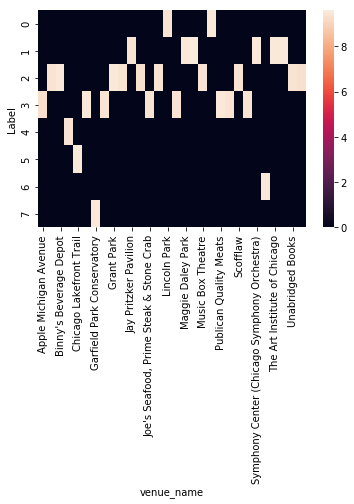

In [21]:
sns.heatmap(restaurant_col_plot)

D:\Work\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


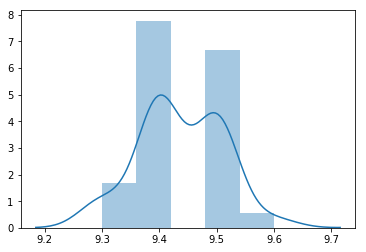

In [22]:
restaurant_col_dist = restaurant_col.groupby('venue_name')[['venue_score']].mean()
sns.distplot(restaurant_col_dist)

### Step 3: Create the folium map <a name = "map"></a>

In [23]:
from matplotlib import cm
from matplotlib import colors
import folium

In [24]:
keys = restaurant_type_on_map.columns.values.tolist()
i1 = restaurant_col.set_index(keys).index
i2 = restaurant_type_on_map.set_index(keys).index
restaurant_col_condensed = restaurant_col[i1.isin(i2)]
restaurant_col_condensed.head()

,venue_id,food_name,food_cat,food_lat,food_lng,venue_name,venue_score,venue_address,venue_lat,venue_lng,Label,color_index
21,42b75880f964a52090251fe3,Remington's,American Restaurant,41.882628,-87.624608,Millennium Park,9.6,201 E Randolph St (btwn Columbus Dr & Michigan...,41.883112,-87.623851,1,15
22,42b75880f964a52090251fe3,Macy's Marketplace Grill,American Restaurant,41.883634,-87.626099,Millennium Park,9.6,201 E Randolph St (btwn Columbus Dr & Michigan...,41.883112,-87.623851,1,15
23,42b75880f964a52090251fe3,Sweetwater Tavern & Grille,American Restaurant,41.886405,-87.624408,Millennium Park,9.6,201 E Randolph St (btwn Columbus Dr & Michigan...,41.883112,-87.623851,1,15
24,42b75880f964a52090251fe3,The Walnut Room,American Restaurant,41.883363,-87.628565,Millennium Park,9.6,201 E Randolph St (btwn Columbus Dr & Michigan...,41.883112,-87.623851,1,15
25,49e9ef74f964a52011661fe3,Macy's Marketplace Grill,American Restaurant,41.883634,-87.626099,The Art Institute of Chicago,9.5,111 S Michigan Ave (btwn Monroe St & Jackson D...,41.879610,-87.623552,1,15


In [25]:
n_rainbow_venue = restaurant_pivot.Label.max() + 1
color_array_venue = cm.rainbow(np.linspace(0, 1, n_rainbow_venue))
color_venue = [colors.rgb2hex(i) for i in color_array_venue]
n_rainbow_food = restaurant_col_condensed.color_index.max() + 1
color_array_food = cm.rainbow(np.linspace(0, 1, n_rainbow_food))
color_food = [colors.rgb2hex(i) for i in color_array_food]

In [26]:
def add_marker(location_input, color_map, marker_size, food_map):
    for lat, lng, color_index, name in zip(location_input.iloc[:, 0], location_input.iloc[:, 1], 
                                           location_input.iloc[:, 2], location_input.iloc[:, 3]):
        pop_up = folium.Popup(name, parse_html = True)
        folium.CircleMarker(location = [lat, lng], radius = marker_size, popup = pop_up,
                            color = color_map[color_index], fill = True, fill_color = color_map[color_index], 
                            fill_opacity = 0.7).add_to(food_map)


In [56]:
def label_color(data_input, color_map):
    df_label_color = data_input.iloc[:, 2].drop_duplicates()
    label_to_color = [(str(v), color_map[v]) for v in df_label_color]
    print ([': '.join(pair) for pair in label_to_color])

In [57]:
map_food = folium.Map(location = [map_lat, map_lng], zoon_start = 11)
food_input = restaurant_col_condensed[['food_lat', 'food_lng', 'color_index', 'food_cat']]
venue_input = restaurant_col_condensed[['venue_lat', 'venue_lng', 'Label', 'venue_name']].drop_duplicates()

add_marker(food_input, color_food, 2, map_food)
add_marker(venue_input, color_venue, 4, map_food)

label_color(food_input, color_food)
label_color(venue_input, color_venue)

map_food

['15: #2884f6', '9: #4c50fc', '86: #ff0000', '18: #169bf2', '78: #ff4724', '7: #583efd', '46: #90feab', '40: #6efebe', '12: #396bf9', '38: #62fbc4', '23: #08bee9', '44: #84ffb2', '69: #ff934d', '76: #ff592d', '73: #ff733b']
['1: #386df9', '2: #12c8e6', '3: #5af8c8', '7: #ff0000', '5: #ecc86f', '0: #8000ff', '4: #a4f89f', '6: #ff6d38']


# Results and Discussion <a name = "results"></a>

To answer the question that where to open your first restaurant and succeed, we need to perform this two-step analysis:
* __Near which venue to open the restaurant?__
* __What type of restaurant to open?__

To answer the first question, let's look at the bigger markers on the folium map and their catergories. As mentioned in the Step 1 of the Analysis section, we'd like to avoid opening the restaurants that are in the top three restaurant categories of each label. Furthermore, as seen in the Step 2 of the Analysis section, the average restaurant scores across all the venues are distributed across 9.3 to 9.7, indicating that we won't be disadvantaged by avoiding some competition. We should also notice that restaurant competition are more intense in the central downtown area, meaning more opportunities. So there it is. The ideal location for our first Chicargo restaurant is the central downtown Chicargo.

After selecting the venue location, we then take a look at those small markers on the folium map to determine which restaurant type to open. Based on our assumptions above, we have decided to avoid opening any top three restaurant categories in the selected label. Let's return to the Step 4 of the Methodology section and review the "restaurant_top_count" table. The cells highlighted in green are our target restaurant type. Since our selected venue area is populated with Label 1 and 3, our ideal restaurant types are either American or Italian restaurant. We can even go one step further and create an Italian and American fusion restaurant.  

Additionally, further cost-benefit analysis needs to be performed to decide the potential upfront capital investments. We should also consider the local demographics including average annual salary level and population size. Please keep in mind that the restaurant type that only attracts tourists will incur unexpected losts when entering the light tourism season.

# Conclusion <a name = "conclusion"> </a>
Based on the above discussion, we try to select the Chicago area where presents us with the most business opportunities but modest competition. To achieve this goal, we first using KMeans to cluster all the venue locations based on their restaurant information. We find that the central downtown Chicago area has the most concentrated folium markers, indicating this is the potentially most popular area in Chicago. Then to analyze the intensity of the local restaurant competition, we use the heatmap as well as distribution plot from seaborn to visualize the number of the restaurants opened and their average score. We decide to avoid the competition by chosing the forth popular restaurant type, and the average restaurant score distribution indicates that we are unlikely to sacrifice any business. After matching the color marker with the label, we decide to open an American & Italian restaurant.

# Central Downtown Chicago, Italian & American Restaurant, There We Go !!!!